## These are failed attempts on finding data structures on the different SKU in order to make modelling decissions based on possible clusters. But this approach didn't work

In [5]:
''' PACKAGES'''
import pandas as pd             

import numpy as np

import seaborn as sns
sns.set(style="dark", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

In [6]:
''' DATA PRE-PROCESSING'''
df=pd.read_csv('train.csv')
df.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df['sku']=df['sku'].apply(str)
df['week'] = df['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df['week']=df['week'].apply(dateFormat)

In [7]:
skus=df['sku'].drop_duplicates().reset_index(drop=True)
skus_s=df.loc[df['scope']==1]['sku'].drop_duplicates().reset_index(drop=True)
week=df['week'].drop_duplicates().reset_index(drop=True).to_frame()

In [8]:
### Time series of All SKU
target=week.copy()
price=week.copy()
nos_w1=week.copy()
vop_w1=week.copy()
sales_w1=week.copy()
for index, row in skus.items():
    target[row]=df[df['sku']==row].reset_index()['target']
    price[row]=df[df['sku']==row].reset_index()['price']
    nos_w1[row]=df[df['sku']==row].reset_index()['nos_w-1']
    vop_w1[row]=df[df['sku']==row].reset_index()['vop_w-1']
    sales_w1[row]=df[df['sku']==row].reset_index()['sales_w-1']
target.set_index('week',inplace=True)
price.set_index('week',inplace=True)
nos_w1.set_index('week',inplace=True)
vop_w1.set_index('week',inplace=True)
sales_w1.set_index('week',inplace=True)
nos_w1.dropna(inplace=True)
vop_w1.dropna(inplace=True)
sales_w1.dropna(inplace=True)
### Time series of Scope SKU
target_s=week.copy()
price_s=week.copy()
nos_w1_s=week.copy()
vop_w1_s=week.copy()
sales_w1_s=week.copy()
for index, row in skus.items():
    if df[df['sku']==row]['scope'].iloc[0]==1:
        target_s[row]=df[df['sku']==row].reset_index()['target']
        price_s[row]=df[df['sku']==row].reset_index()['price']
        nos_w1_s[row]=df[df['sku']==row].reset_index()['nos_w-1']
        vop_w1_s[row]=df[df['sku']==row].reset_index()['vop_w-1']
        sales_w1_s[row]=df[df['sku']==row].reset_index()['sales_w-1']
target_s.set_index('week',inplace=True)
price_s.set_index('week',inplace=True)
nos_w1_s.set_index('week',inplace=True)
vop_w1_s.set_index('week',inplace=True)
sales_w1_s.set_index('week',inplace=True)
nos_w1_s.dropna(inplace=True)
vop_w1_s.dropna(inplace=True)
sales_w1_s.dropna(inplace=True)

In [9]:
sku=df['sku'].copy().to_frame()
sku_s=df[df['scope']=='1']['sku'].copy().to_frame()
sku_features=['pack', 'size', 'brand','scope']
for features in sku_features:
    sku[features]=df[features].copy()
    sku_s[features]=df[features].copy()

sku.drop_duplicates(inplace=True)
sku_s.drop_duplicates(inplace=True)
sku.set_index('sku',inplace=True)
sku_s.set_index('sku',inplace=True)


try:
    sku['pack_n']=sku['pack'].replace(['SINGLE','MULTI'], [0,1]).apply(int)
except:
    pass
try:
    sku['brand_n']=sku['brand'].map(lambda x: x.lstrip('BRAND')).apply(int)-1
except:
    pass

time_series=['target','price','nos_w1','vop_w1']
for ts in time_series:
    sku[str(ts)+'_mean']=eval(ts).mean()
    sku[str(ts)+'_std']=eval(ts).std()

def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
sku['adf']=ADFuller(target)['p-value'].apply(float)

C:\Users\asus\miniconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [10]:
lags=2
variables=['price[row].shift(lag).dropna()', 'nos_w1[row].shift(lag).dropna()',
           'vop_w1[row].shift(lag).dropna()','sales_w1[row].shift(lag).dropna()']
names=['price', 'nos_w1','vop_w1','sales_w1']
targets=['target[row][lag:]','target[row][lag+1:]','target[row][lag+1:]','target[row][lag+1:]']
for lag in range(0,lags+1):
    for variable,t,name in zip(variables,targets,names):
        pearsons=np.ones((target.shape[1]))*np.nan
        for i,row in skus.iteritems():
            pearsons[i]=pearsonr(eval(t),eval(variable))[0]
        sku[name+'_'+str(lag)]=pearsons

C:\Users\asus\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
sku=sku.drop(index=sku[sku['adf']>.1].index)

In [12]:
sku.shape

(29, 27)

In [13]:
sku.columns

Index(['pack', 'size', 'brand', 'scope', 'pack_n', 'brand_n', 'target_mean',
       'target_std', 'price_mean', 'price_std', 'nos_w1_mean', 'nos_w1_std',
       'vop_w1_mean', 'vop_w1_std', 'adf', 'price_0', 'nos_w1_0', 'vop_w1_0',
       'sales_w1_0', 'price_1', 'nos_w1_1', 'vop_w1_1', 'sales_w1_1',
       'price_2', 'nos_w1_2', 'vop_w1_2', 'sales_w1_2'],
      dtype='object')

In [14]:
full_pca_model = PCA()
X=sku[['price_0', 'nos_w1_0', 'vop_w1_0',
       'sales_w1_0', 'price_1', 'nos_w1_1', 'vop_w1_1', 'sales_w1_1',
       'price_2', 'nos_w1_2', 'vop_w1_2', 'sales_w1_2']].dropna()
X_std = StandardScaler().fit_transform(X)
full_fitted_model = full_pca_model.fit(X_std)

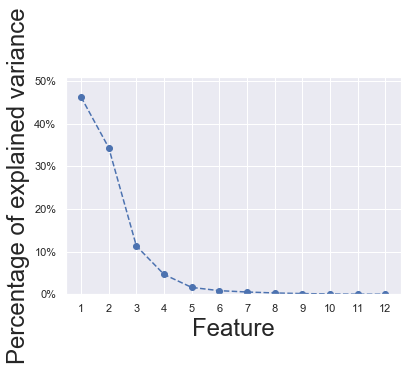

In [15]:
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,X.shape[1],1),labels=np.arange(1,X.shape[1]+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,X.shape[1],1),labels=np.arange(1,X.shape[1]+1,1));
plt.yticks(np.arange(0.0,0.51,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.51,.1)]);
plt.ylim([0.0,0.51]);
plt.grid()

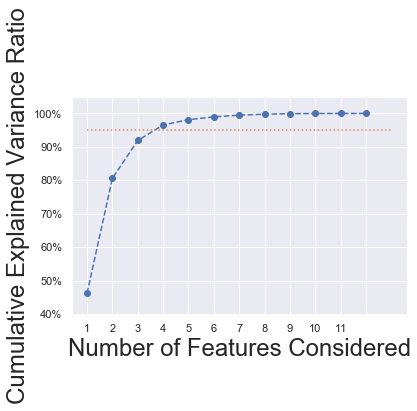

In [16]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,X.shape[1],1),labels=np.arange(1,X.shape[1],1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,X.shape[1]],[.95,.95],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");
plt.grid()

In [17]:
feature_selection_pca_model = PCA(n_components=3, whiten=True)
component_labels = ['Component '+str(x+1) for x in range(3)]
fitted_model = feature_selection_pca_model.fit(X_std)
X_selected_features_pca = fitted_model.transform(X_std)
X_pca=pd.DataFrame(X_selected_features_pca,columns=component_labels,index=X.index)

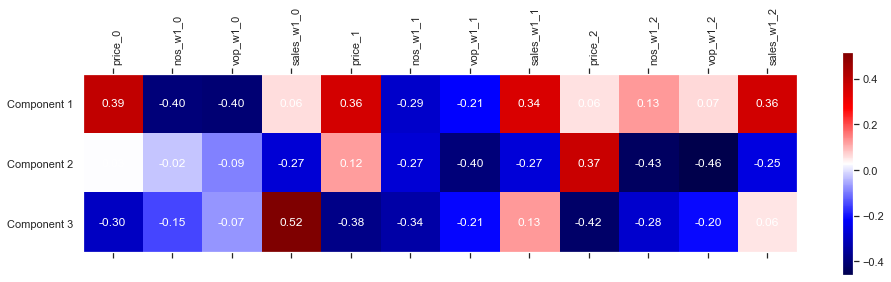

In [19]:
number_of_components = feature_selection_pca_model.components_.shape[0]
number_of_variables = feature_selection_pca_model.components_.shape[1]
component_ticks = np.arange(0,number_of_components,1)


# plt.figure(figsize=(number_of_components*3,number_of_variables*3));
plt.matshow(feature_selection_pca_model.components_, cmap='seismic');
plt.yticks(component_ticks, labels=component_labels);
plt.colorbar();
plt.grid(False);
plt.xticks(range(X.shape[1]),X.columns,rotation=90,ha='left');
for (i, j), z in np.ndenumerate(feature_selection_pca_model.components_):
    plt.text(j, i, '{:0.2f}'.format(z),fontsize=12, ha='center', va='center',color="white");
plt.show();# 

In [253]:
sku=sku.join(X_pca, lsuffix='_caller', rsuffix='_other')

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

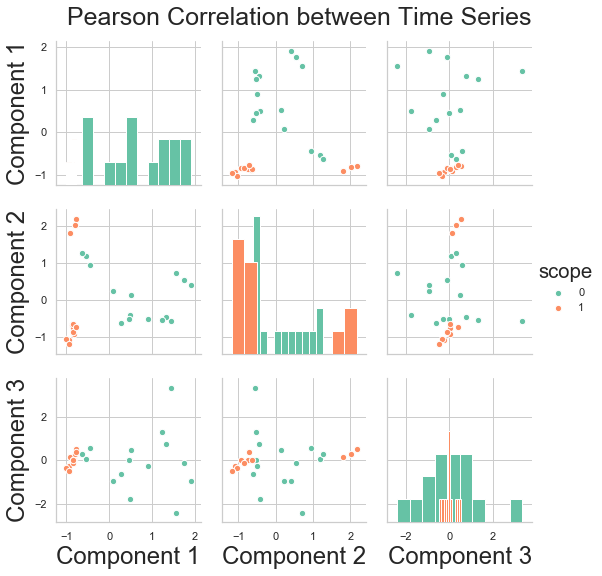

In [254]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['Component 1','Component 2','Component 3',
                    'scope']].dropna(),
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

In [255]:
merges = linkage(sku[['Component 1','Component 2','Component 3']].dropna(), method = 'single')
print('there have been %d merges'%(merges.shape[0]))

there have been 26 merges


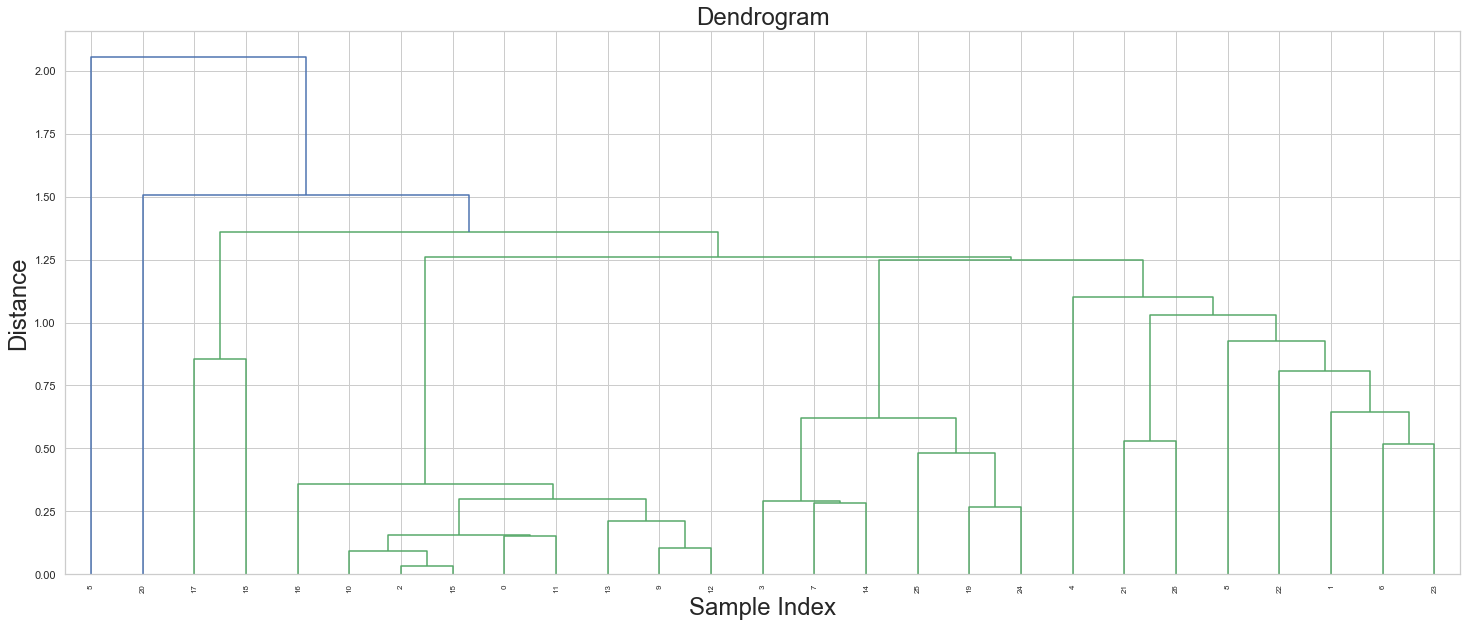

In [256]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(merges, 
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [257]:
def ComputeInternalMeasures(x, merges, k_values):
    wss_values = {}
    bss_values = {}

    for k in k_values:
        clustering = fcluster(merges, k, criterion='maxclust')
        centroids = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
        cdist(x, centroids, 'euclidean')
        D = cdist(x, centroids, 'euclidean')
        cIdx = np.argmin(D,axis=1)
        d = np.min(D,axis=1)

        avgWithinSS = sum(d)/x.shape[0]

        # Total with-in sum of square
        wss = sum(d**2)

        tss = sum(pdist(x)**2)/x.shape[0]

        bss = tss-wss

        wss_values[k] = wss
        bss_values[k] = bss
    return wss_values,bss_values

In [258]:
k=20
k_values = range(1,k)
wss_dict, bss_dict = ComputeInternalMeasures(sku[component_labels].dropna(), merges, k_values)
wss_values = [wss_dict[x] for x in range(1,k)]
bss_values = [bss_dict[x] for x in range(1,k)]

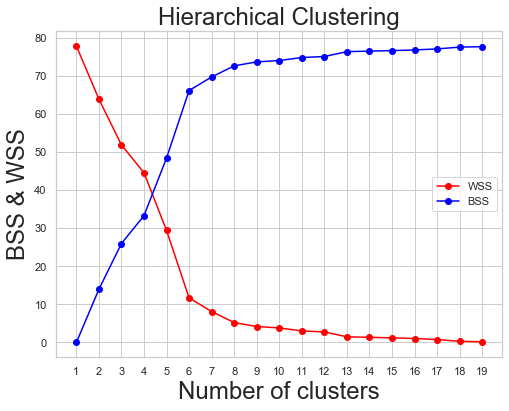

In [259]:
fig = plt.figure(figsize=(8,6))
font = {'family' : 'sans', 'size'   : 16}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

In [260]:
labels = pd.DataFrame(fcluster(merges,6,criterion='maxclust'),columns=['labels'],index=X.index)

sku['labels']=labels['labels']

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

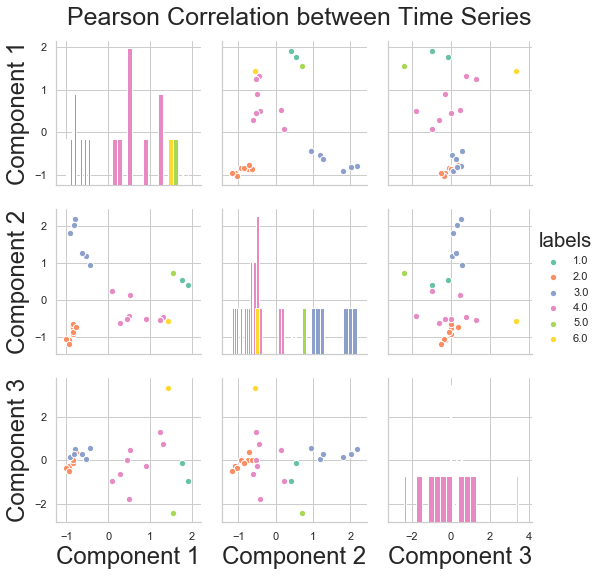

In [261]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['labels','Component 1', 'Component 2', 'Component 3']],
               hue='labels',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

In [262]:
def defineClusters(label):
    if label==2:
        return 'Cluster 1'
    elif label==3:
        return 'Cluster 2'
    else:
        return 'No Cluster'
sku['labels']=sku['labels'].apply(defineClusters)
sku=sku.drop(index=sku[sku['labels']=='No Cluster'].index)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

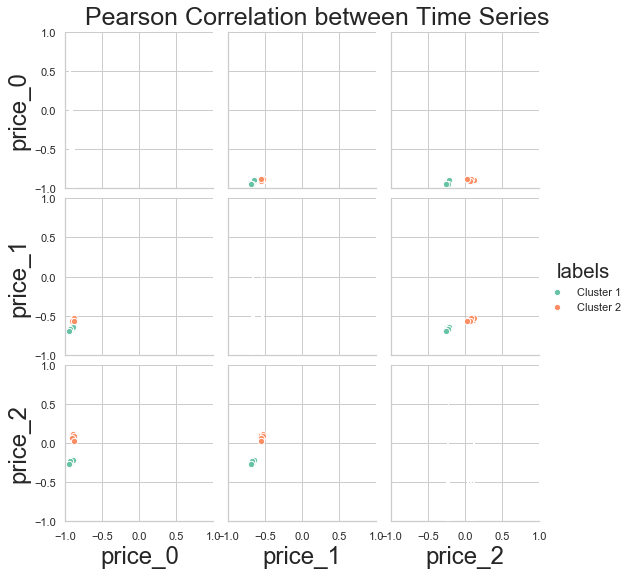

In [263]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['labels','price_0',  'price_1', 'price_2']],
               hue='labels',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

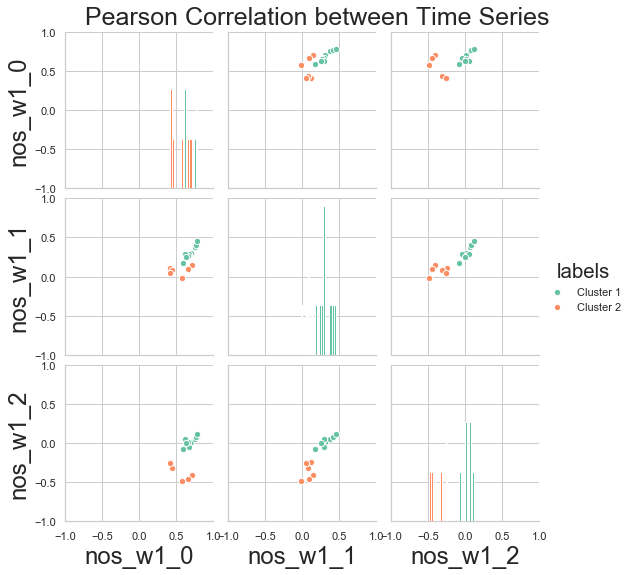

In [264]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['labels','nos_w1_0',  'nos_w1_1', 'nos_w1_2']],
               hue='labels',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

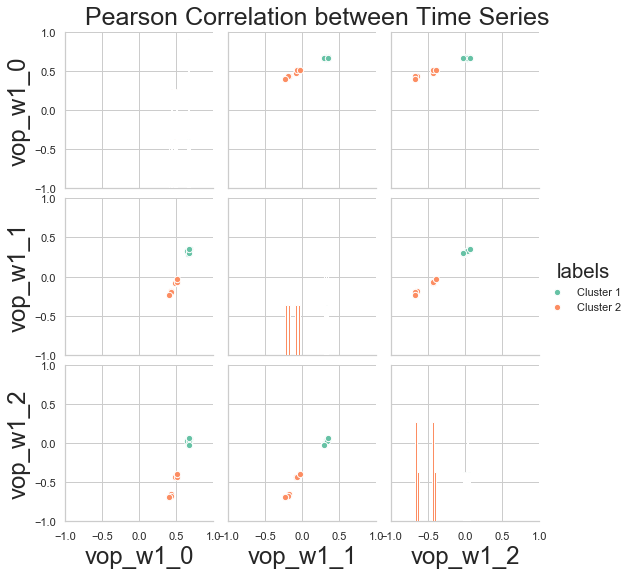

In [265]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['labels','vop_w1_0',  'vop_w1_1', 'vop_w1_2']],
               hue='labels',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

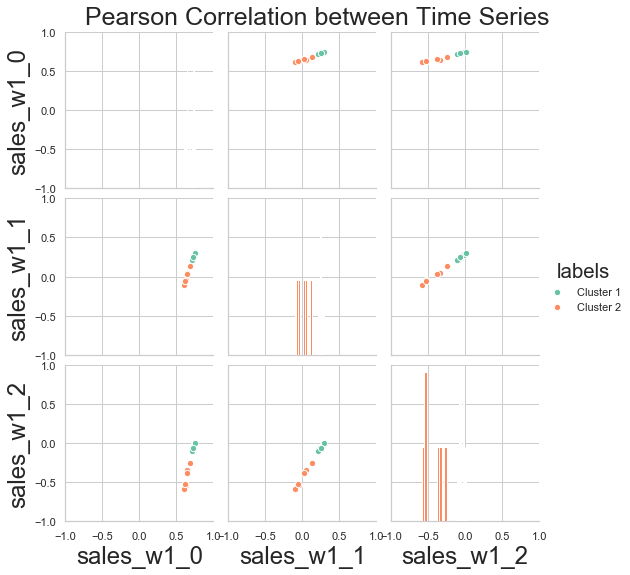

In [266]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['labels','sales_w1_0',  'sales_w1_1', 'sales_w1_2']],
               hue='labels',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

In [267]:
display(sku.loc[sku['labels']=='Cluster 1'].describe())
display(sku.loc[sku['labels']=='Cluster 2'].describe())
display(sku.columns)

,size,scope,pack_n,brand_n,target_mean,target_std,price_mean,price_std,nos_w1_mean,nos_w1_std,...,nos_w1_1,vop_w1_1,sales_w1_1,price_2,nos_w1_2,vop_w1_2,sales_w1_2,Component 1,Component 2,Component 3
count,9.000000,9.0,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,119.305556,1.0,0.0,1.888889,88272.722640,42868.442487,0.490710,0.088995,5.461279,8.523524,...,0.313794,0.319563,0.252967,-0.240503,0.020314,0.018938,-0.058159,-0.875623,-0.871734,-0.078067
std,6.018868,0.0,0.0,1.054093,41306.722854,16532.092250,0.007935,0.005349,2.425102,3.025633,...,0.085665,0.021238,0.027330,0.013008,0.062009,0.030623,0.037699,0.071148,0.196946,0.249405
min,114.230000,1.0,0.0,1.000000,48221.248120,25209.250453,0.481053,0.079530,3.181818,5.021812,...,0.174552,0.290167,0.217075,-0.263586,-0.082207,-0.030817,-0.107237,-1.006279,-1.183852,-0.471456
25%,114.230000,1.0,0.0,1.000000,63473.548872,28873.913670,0.485188,0.085067,3.492424,5.608739,...,0.264549,0.303688,0.236066,-0.243598,-0.005284,0.001804,-0.083545,-0.935414,-1.042225,-0.264340
50%,114.230000,1.0,0.0,1.000000,66936.556391,40510.106548,0.487820,0.090674,4.196970,8.148556,...,0.293929,0.318762,0.246642,-0.238126,0.011144,0.025098,-0.069648,-0.848712,-0.851676,0.016312
75%,125.650000,1.0,0.0,3.000000,111831.511278,53594.949721,0.496090,0.092800,6.560606,10.483908,...,0.380839,0.329402,0.278612,-0.234217,0.058002,0.030182,-0.019654,-0.840798,-0.713898,0.022658
max,125.650000,1.0,0.0,3.000000,171707.218045,75587.706163,0.502105,0.094671,9.484848,13.038103,...,0.450762,0.352278,0.296459,-0.219970,0.116721,0.067079,0.005084,-0.770283,-0.638171,0.369985


,size,scope,pack_n,brand_n,target_mean,target_std,price_mean,price_std,nos_w1_mean,nos_w1_std,...,nos_w1_1,vop_w1_1,sales_w1_1,price_2,nos_w1_2,vop_w1_2,sales_w1_2,Component 1,Component 2,Component 3
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,258.626667,0.500000,0.500000,3.166667,24883.174185,14588.834491,2.245714,0.454917,9.440657,12.555612,...,0.076146,-0.133405,-0.000116,0.085925,-0.362071,-0.546024,-0.436766,-0.679958,1.564364,0.317256
std,149.896648,0.547723,0.547723,1.169045,17209.938862,13493.913513,0.510864,0.263968,8.600285,9.213719,...,0.058665,0.079579,0.086693,0.033495,0.104354,0.139439,0.131616,0.179044,0.504235,0.210077
min,114.230000,0.000000,0.000000,1.000000,7471.593985,2362.466601,1.773910,0.213465,1.416667,2.955243,...,-0.023233,-0.230742,-0.103223,0.028282,-0.488333,-0.683893,-0.587909,-0.902856,0.935477,0.052970
25%,125.650000,0.000000,0.000000,3.000000,10524.304511,3215.331750,1.781917,0.213858,2.356061,5.487050,...,0.056690,-0.192721,-0.056312,0.073973,-0.443682,-0.673909,-0.530082,-0.797668,1.200573,0.174544
50%,260.530000,0.500000,0.500000,3.500000,21670.654135,10614.806127,2.246316,0.455092,7.056818,10.249745,...,0.084841,-0.133506,-0.010712,0.093882,-0.366167,-0.543747,-0.453561,-0.703271,1.538822,0.297647
75%,395.410000,1.000000,1.000000,4.000000,38241.398496,25486.200887,2.710263,0.695349,16.064394,20.053177,...,0.109060,-0.075060,0.043826,0.106323,-0.271473,-0.433125,-0.351993,-0.556075,1.968033,0.485305
max,395.410000,1.000000,1.000000,4.000000,47912.308271,32748.755328,2.715714,0.696969,21.257576,24.658467,...,0.145986,-0.034641,0.133455,0.121697,-0.242334,-0.391212,-0.251837,-0.434206,2.174135,0.573902


Index(['pack', 'size', 'brand', 'scope', 'pack_n', 'brand_n', 'target_mean',
       'target_std', 'price_mean', 'price_std', 'nos_w1_mean', 'nos_w1_std',
       'vop_w1_mean', 'vop_w1_std', 'adf', 'price_0', 'nos_w1_0', 'vop_w1_0',
       'sales_w1_0', 'price_1', 'nos_w1_1', 'vop_w1_1', 'sales_w1_1',
       'price_2', 'nos_w1_2', 'vop_w1_2', 'sales_w1_2', 'Component 1',
       'Component 2', 'Component 3', 'labels'],
      dtype='object')

In [288]:
scaler = StandardScaler()
variables=['price_0', 'nos_w1_0', 'vop_w1_0',
       'sales_w1_0', 'price_1', 'nos_w1_1', 'vop_w1_1', 'sales_w1_1',
       'price_2', 'nos_w1_2', 'vop_w1_2', 'sales_w1_2']
normalized_data = scaler.fit_transform(sku[variables])
df_normalized = pd.DataFrame(normalized_data,columns=variables)
df_normalized['labels'] = sku['labels'].reset_index(drop=True)
df_melt = pd.melt(df_normalized, 
                    id_vars=['labels'],
                    value_vars=variables, 
                    var_name='Attribute', 
                    value_name='Value')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

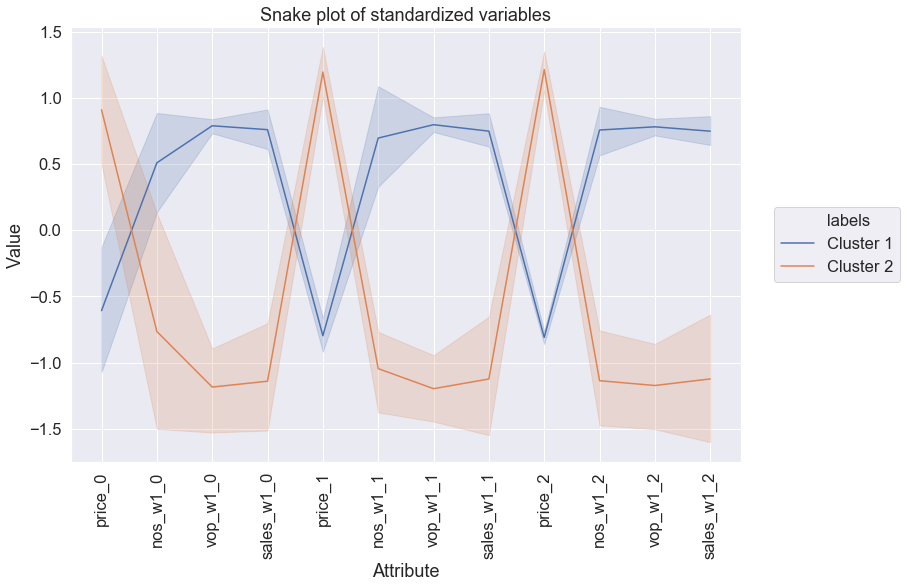

In [289]:
plt.title('Snake plot of standardized variables')
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.lineplot(x="Attribute", y="Value", hue='labels', data=df_melt,sort=False)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xticks(rotation='vertical')

In [270]:
sku['labels']

sku
1027    Cluster 1
1035    Cluster 1
144     Cluster 2
1051    Cluster 2
546     Cluster 1
1058    Cluster 1
549     Cluster 1
1065    Cluster 1
554     Cluster 1
686     Cluster 2
688     Cluster 1
1206    Cluster 1
2249    Cluster 2
2401    Cluster 2
2410    Cluster 2
Name: labels, dtype: object